In [1]:
import pandas as pd
import numpy as np
import os, sys
import random
import pydicom

from sklearn.manifold import TSNE
import re
import matplotlib.pyplot as plt
import matplotlib.cm as cm
seed = 2024

import warnings
warnings.filterwarnings("ignore")

# ML tools 
sys.path.append("/kaggle/input/kimm-keras-image-model-repository"
               )

import tensorflow as tf
import keras# ; keras.config.set_dtype_policy("mixed_float16")
import kimm
import keras_cv
import keras_nlp

import cv2
from skimage.io import imread
keras.utils.set_random_seed(seed)
import tensorflow_io as tfio
from kaggle_datasets import KaggleDatasets
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tensorflow_decision_forests as tfdf

print(f"Tensorflow version : {tf.__version__}")
try:
    print(f"Keras version : {keras.__version__}")
except:
    pass

from keras import Input, Model, ops
from keras.models import load_model

from keras.layers import Conv2D, DepthwiseConv2D, Dense, Activation, BatchNormalization, LayerNormalization, MultiHeadAttention, Embedding, Subtract, Add, Multiply, GlobalAveragePooling2D, GlobalAveragePooling1D, LayerNormalization
from keras.utils import load_img, img_to_array
from keras.applications import *
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tqdm.notebook import tqdm
import wandb
#from wandb.keras import WandbCallback, WandbModelCheckpoint, WandbMetricsLogger
def wandb_config():
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    try:
        secret_value_0 = user_secrets.get_secret("__gcloud_sdk_auth__")
        secret_value_1 = user_secrets.get_secret("huggingface_key")
        secret_value_2 = user_secrets.get_secret("wandb_key")
        !wandb login $secret_value_2
    except:
        secret_value_0 = user_secrets.get_secret("huggingface_key")
        secret_value_1 = user_secrets.get_secret("wandb_key")
        !wandb login $secret_value_1
    
def auto_select_accelerator():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
    except ValueError:
        tpu = False
        strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return tpu, strategy

tpu, strategy = auto_select_accelerator()
import ssl_module
from ssl_module import feature_visualize, get_masking_fn, get_map_fn, get_gcvit_configs, get_flops, att_visualize, get_full_model, AttentionPooling, BarlowModel, VICRegModel, Moco, SimSiam, CLIP, SigLIP
import nas_ftp_module
from nas_ftp_module import upload_file, download_file

US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<01:31, 1.67kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<02:08, 3.98kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<01:48, 4.47kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<02:58, 5.16kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<07:17, 14.0kB/s]


Tensorflow version : 2.16.1
Keras version : 3.3.3
Running on 1 replicas
Requirements loaded, keras : v3.3.3, Tensorflow : v2.16.1
RandAug Component in this SSL module :  ['random_contrast_1', 'random_brightness_1', 'random_shear', 'random_shear_1', 'random_translation', 'random_translation_1']


# 실험 계획
- token mixer : gMLP vs gaMLP vs Attention
- ConvNeXt vs pure-metaformer
     - if convnext, FE 후 token mixer의 갯수에 따른 변화
     - if convnext, ImageNet weight vs randomly initialized

# Setting hyperparameters

In [19]:
batch_size = 8
batch_size = strategy.num_replicas_in_sync * batch_size
print('batch size', batch_size)

res = int(1.5*256)
small_res = 64

n_multicrop = 2
randaug =keras_cv.layers.RandAugment(
    value_range=(0, 255), magnitude=0.2, magnitude_stddev=0.1, geometric = False
)

grayscale = False # False if using pretrained model, True if from scratch
patch_size = 384//12
heads = 12
att_dims = heads * 32
embed_dims = att_dims * 2

c = 1 if grayscale else 3
if grayscale:
    pretrained_encoder = None
    depth = 6
    registers = 2
    pretrained_note = "gray_metaformer"
else:
    depth = 3
    registers = 0
    pretrained_encoder = keras.applications.ConvNeXtTiny(input_shape = [res,res,3], 
                                                         include_top = False,
                                                       weights = None
                                                        ) ; pretrained_note = f"{pretrained_encoder.name}_RandomInit_TM{depth}"
    for layer in pretrained_encoder.layers:
        layer.dtype_policy = keras.mixed_precision.Policy('mixed_float16')
    
    #depth = 6
    #registers = 0
    #pretrained_encoder = None
    #pretrained_note = f"RGB_metaformer_TM{depth}"
    #patch_size = 24

batch size 8


- radimagenet tfrecord key : image, label
- nih cxr tfrecord key : image_raw, label

# RadImageNet decoding

In [3]:
def _parse_tfrecord(res = res):
    def parse_tfrecord(tfrecord):
        features = {'image': tf.io.FixedLenFeature([], tf.string),
                    'label': tf.io.FixedLenFeature([], tf.int64),
                    }
        x = tf.io.parse_single_example(tfrecord, features)
        image_train = tf.image.decode_jpeg(x['image'], channels=1)
        image_train = _transform_images(res = res)(image_train)
        label = tf.cast(x["label"], tf.int32)
        return (image_train, label)
    
    return parse_tfrecord


def _transform_images(res = res):
    def transform_images(x_train):
        x_train = tf.image.resize_with_pad(x_train, res, res, antialias = True)
        x_train = tf.cast(x_train, tf.uint8)
        return x_train
    return transform_images

def load_tfrecord_dataset(tfrecord_name, res = res, batch_size = batch_size, shuffle=True, buffer_size=10240):
    """load dataset from tfrecord"""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name, compression_type = "GZIP")
    raw_dataset = raw_dataset.repeat()
    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)
    dataset = raw_dataset.map(
        _parse_tfrecord(),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size, drop_remainder = True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_radimagenet_ds = load_tfrecord_dataset("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RagImageNet_Train_GZIP.tfrecord")
val_ds = load_tfrecord_dataset("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RagImageNet_Test_GZIP.tfrecord")

# NIH CXR decoding

In [4]:
def _parse_tfrecord(res = res):
    def parse_tfrecord(tfrecord):
        features = {'image_raw': tf.io.FixedLenFeature([], tf.string),
                    'label': tf.io.FixedLenFeature([], tf.int64),
                    }
        x = tf.io.parse_single_example(tfrecord, features)
        image_train = tf.image.decode_jpeg(x['image_raw'], channels=1)
        image_train = _transform_images(res = res)(image_train)
        label = tf.cast(x["label"], tf.int32)
        return (image_train, label)
    
    return parse_tfrecord


def _transform_images(res = res):
    def transform_images(x_train):
        x_train = tf.image.resize_with_pad(x_train, res, res, antialias = True)
        x_train = tf.cast(x_train, tf.uint8)
        return x_train
    return transform_images

def load_tfrecord_dataset(tfrecord_name, res = res, batch_size = batch_size, shuffle=True, buffer_size=10240):
    """load dataset from tfrecord"""
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.repeat()
    if shuffle:
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)
    dataset = raw_dataset.map(
        _parse_tfrecord(),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    if batch_size:
        dataset = dataset.batch(batch_size, drop_remainder = True)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

nih_cxr_ds = load_tfrecord_dataset("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/nih_cxr_images.tfrecords")

# Merging 2 datasets

In [5]:
train_ds = tf.data.Dataset.sample_from_datasets([train_radimagenet_ds.unbatch(), nih_cxr_ds.unbatch()], weights = [0.75, 0.25]).batch(batch_size, drop_remainder = True).repeat().prefetch(tf.data.AUTOTUNE)
val_ds_ = tf.data.Dataset.sample_from_datasets([train_radimagenet_ds.unbatch(), nih_cxr_ds.unbatch()], weights = [0.75, 0.25]).batch(32, drop_remainder = True).prefetch(tf.data.AUTOTUNE)
#train ds output : ([batch_size, res, res, 1], [batch_size,])
# train data curation
for images, labels in val_ds_.take(1):
    sample_img = images
    labels = labels
    if not grayscale:
        sample_img = tf.image.grayscale_to_rgb(sample_img)
del val_ds_

In [6]:
def get_sobel_fn():
    def sobel_merge(image, label):
        image = image[tf.newaxis, ...]
        rand_num = keras.random.randint(shape = (), minval = 1, maxval = 10)
        if rand_num > 5:
            image = ops.cast(image, 'float32')
            ed = tf.image.sobel_edges(image)[..., 0, :]
            ed_norm = 255.0 * (ed - ops.min(ed)) / (ops.max(ed) - ops.min(ed)) ; del ed
            ed_norm = ops.cast(ed_norm, "uint8")
            image =ops.concatenate([image, ed_norm],
                                  axis = -1)
            image = ops.cast(image, "uint8")
        else:
            try:
                image = tf.image.grayscale_to_rgb(image)
            except:
                pass
        image = image[0]
        return image, label
    return sobel_merge
sobel_merge = get_sobel_fn()

# Convert supervised dataset into SSL dataset

In [20]:
multiview_fn = get_map_fn(res = res, input_type = "supervised", output_type = "ssl",
                         n_view = n_multicrop, grayscale = grayscale)

train_ds_multiview = train_ds.map(multiview_fn, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_ds_multiview = val_ds.map(multiview_fn, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

mask_map_fn_ = get_masking_fn(grayscale = grayscale, masking_rate = 0.7, patch_size = patch_size)

train_edge_ds = train_ds.unbatch().map(sobel_merge, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size, drop_remainder = True).prefetch(tf.data.AUTOTUNE)

def masking_function(image, label):
    sequence, masked_img, aug_img, original_img = mask_map_fn_(image)
    aug_img = randaug(aug_img)
    aug_img = ops.cast(aug_img, "uint8")
    return (sequence, masked_img, aug_img, original_img)

train_ds_masked = train_ds.map(masking_function, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).repeat()
train_ds_edge_masked = train_edge_ds.map(masking_function, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE).repeat()
train_ds_edge_multiview = train_edge_ds.map(multiview_fn, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
#train_ds_edge_simple_multiview = train_edge_ds.map(simple_aug_fn, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

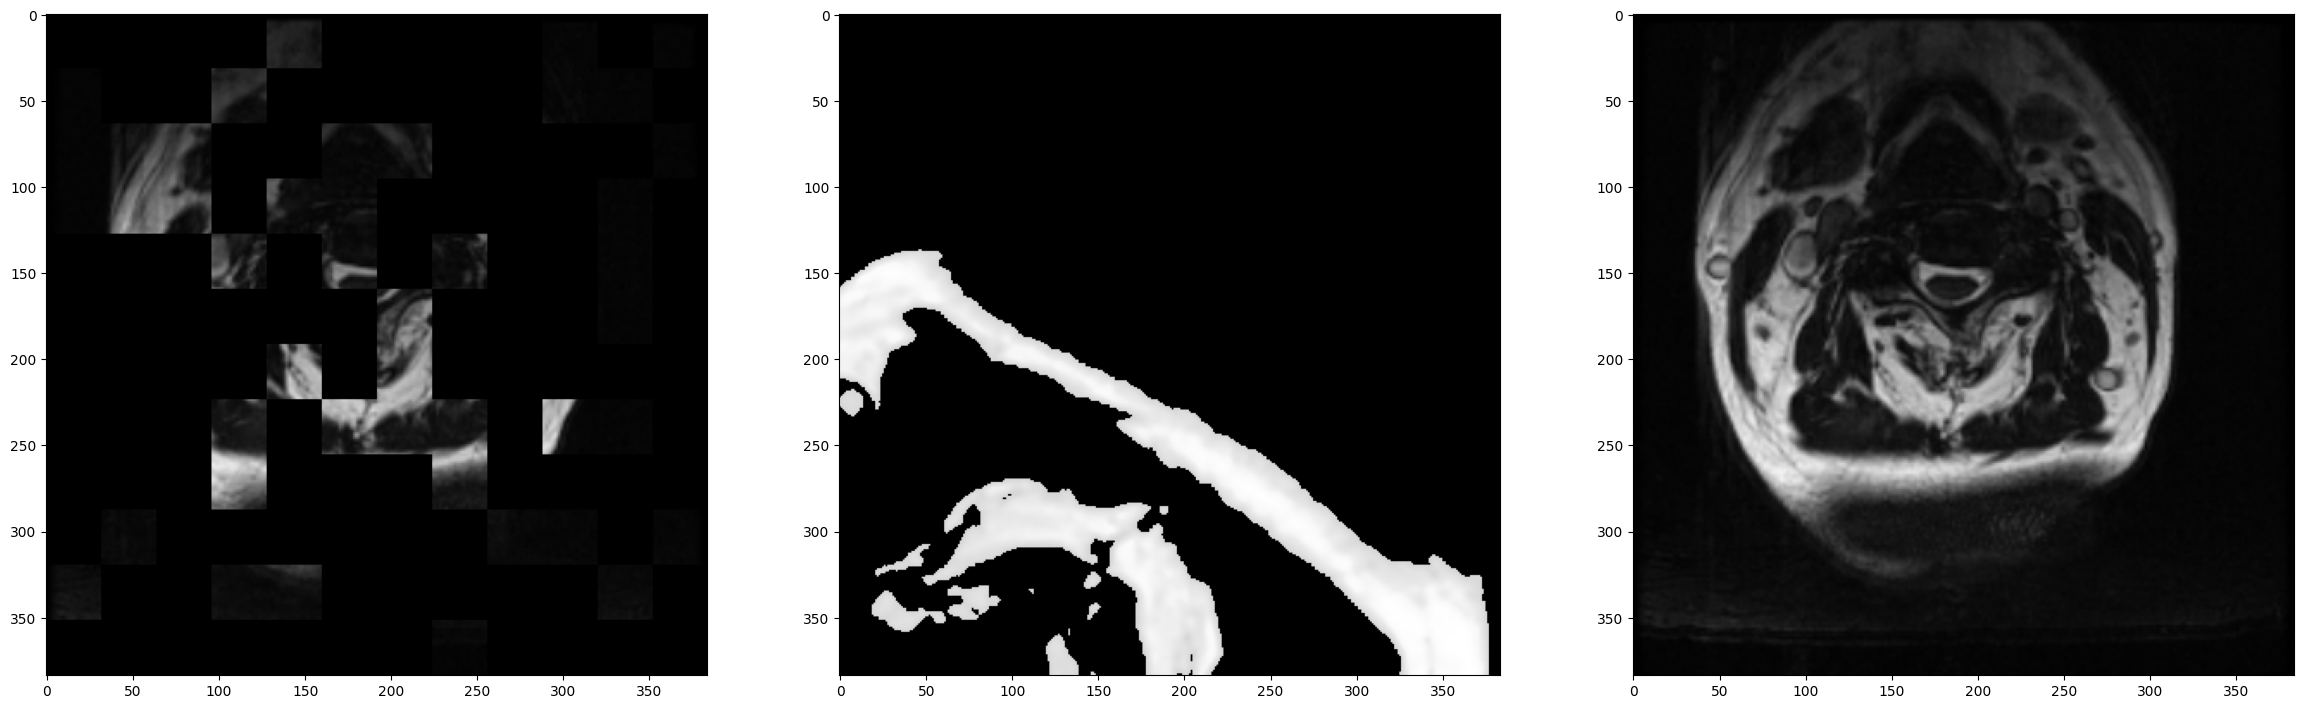

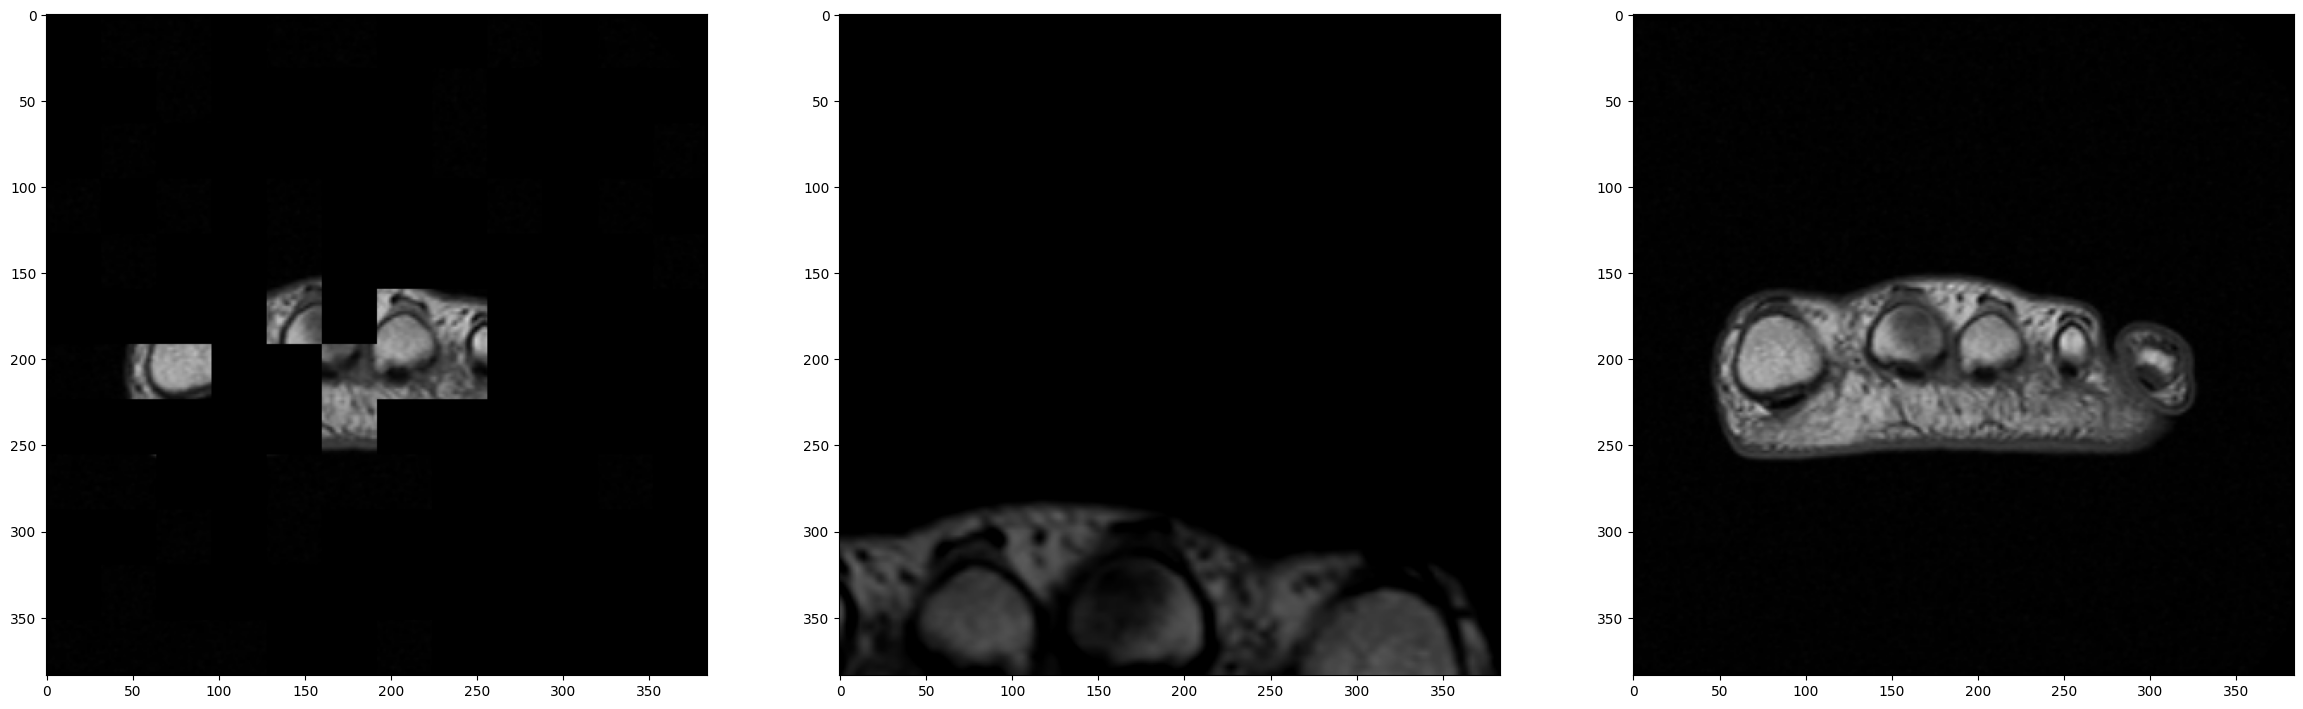

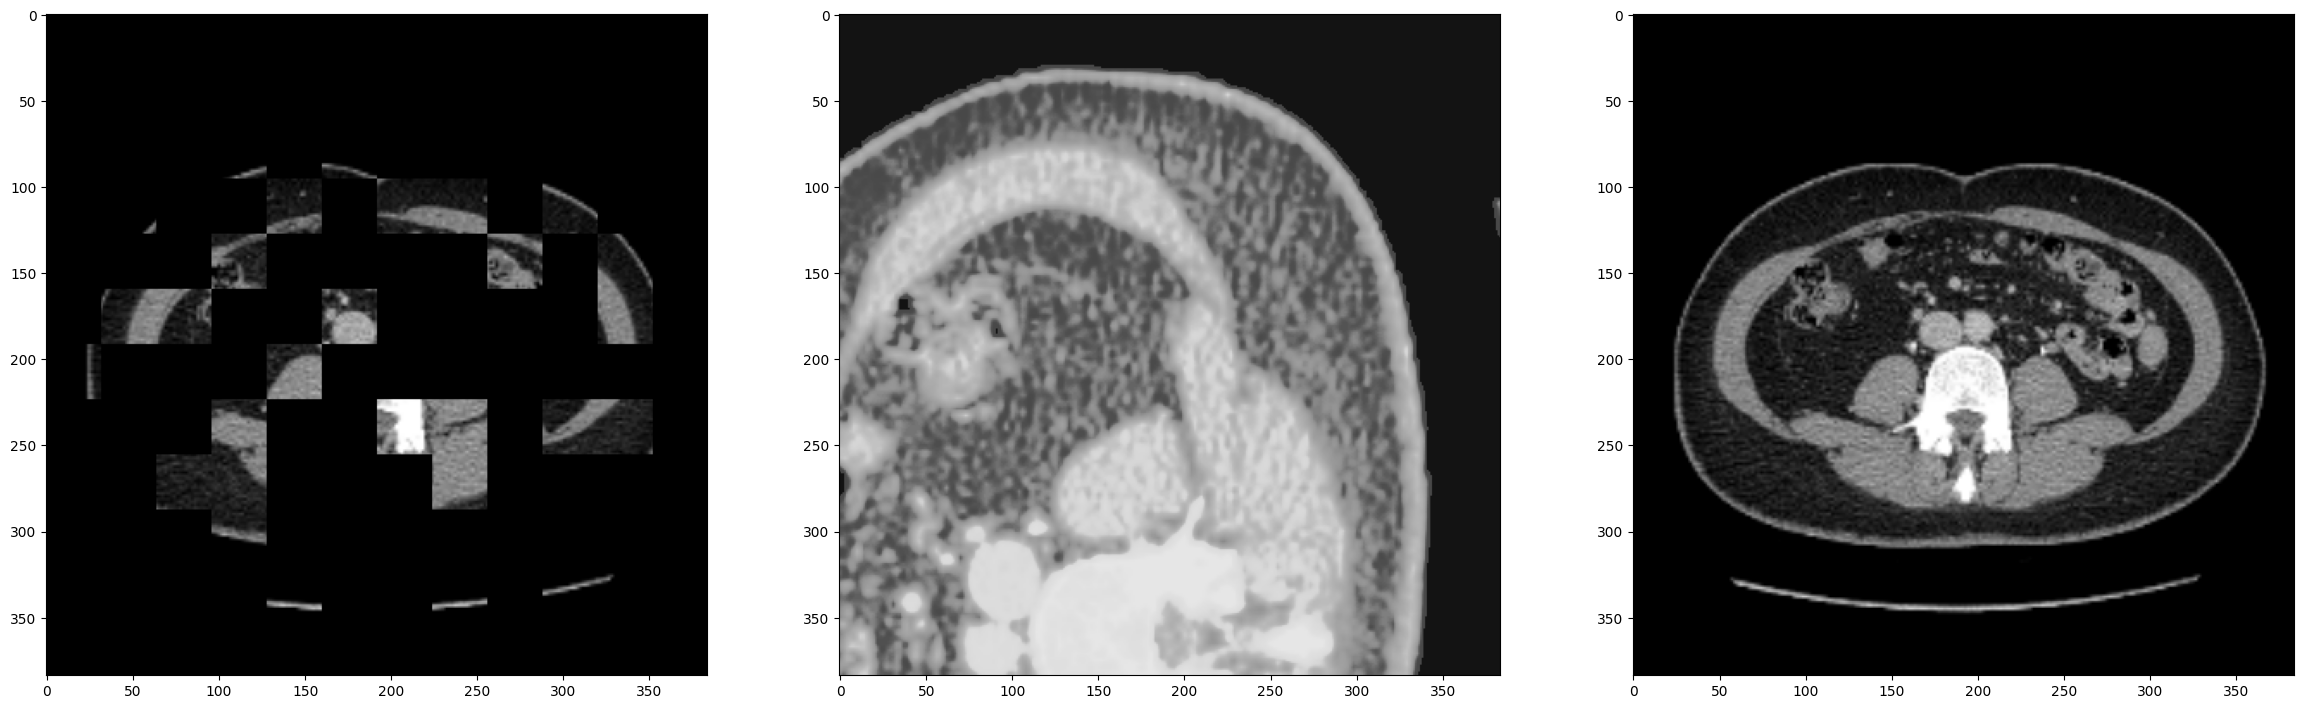

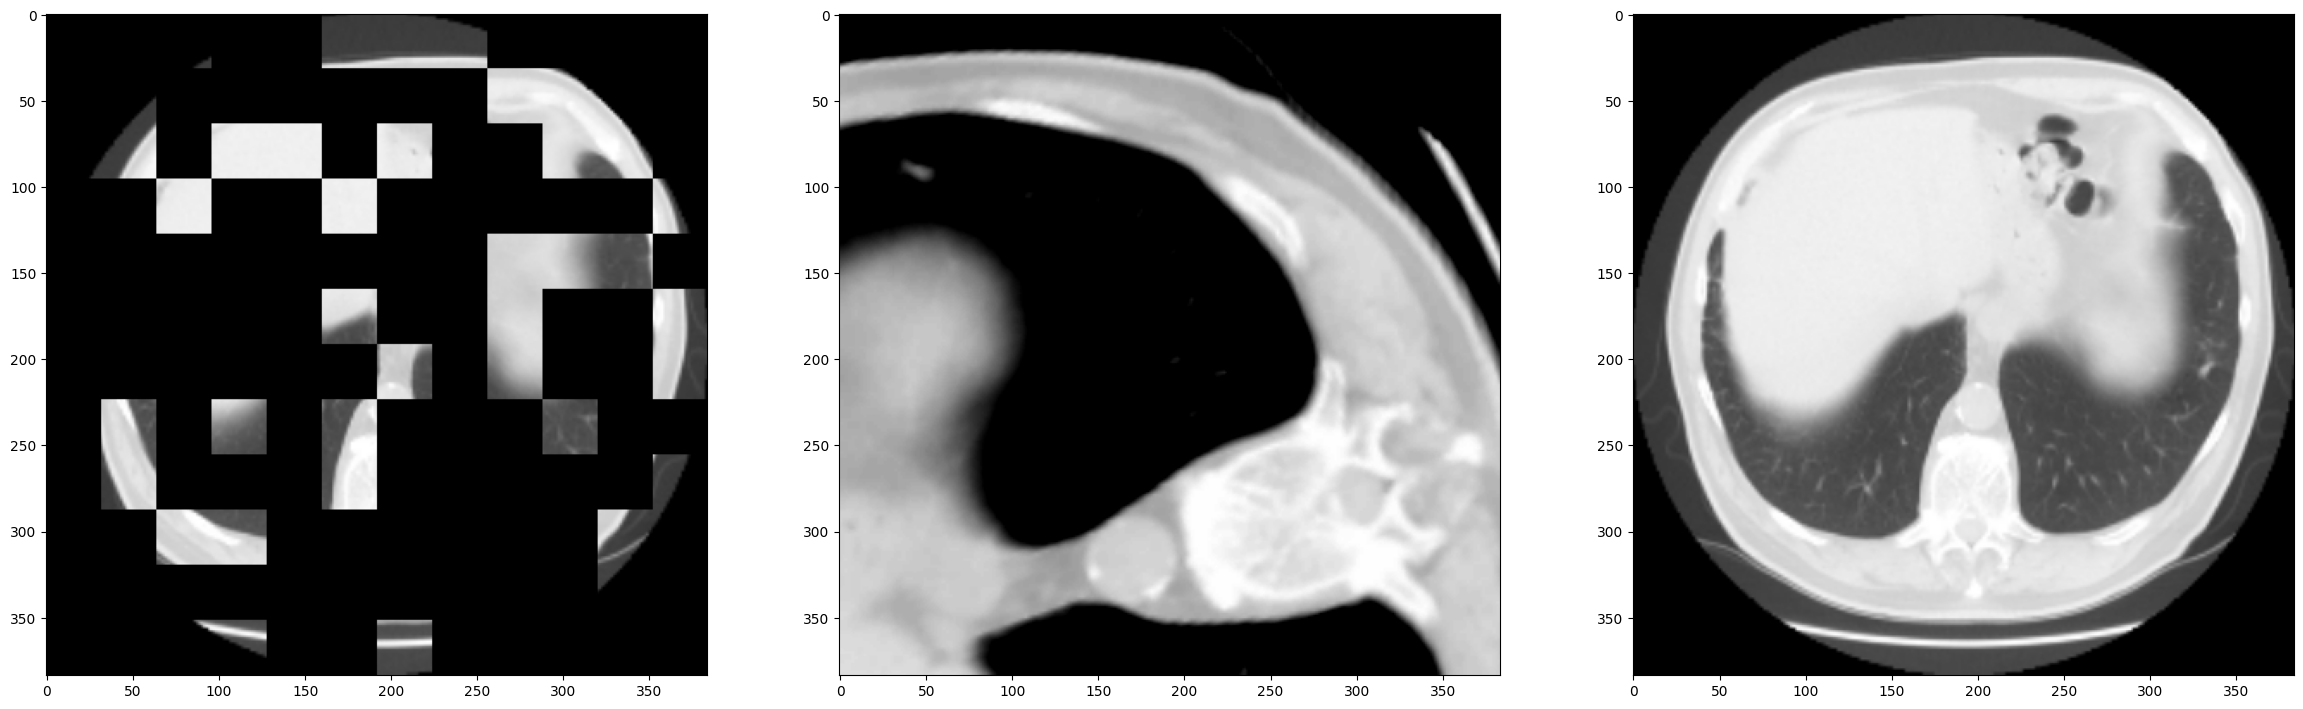

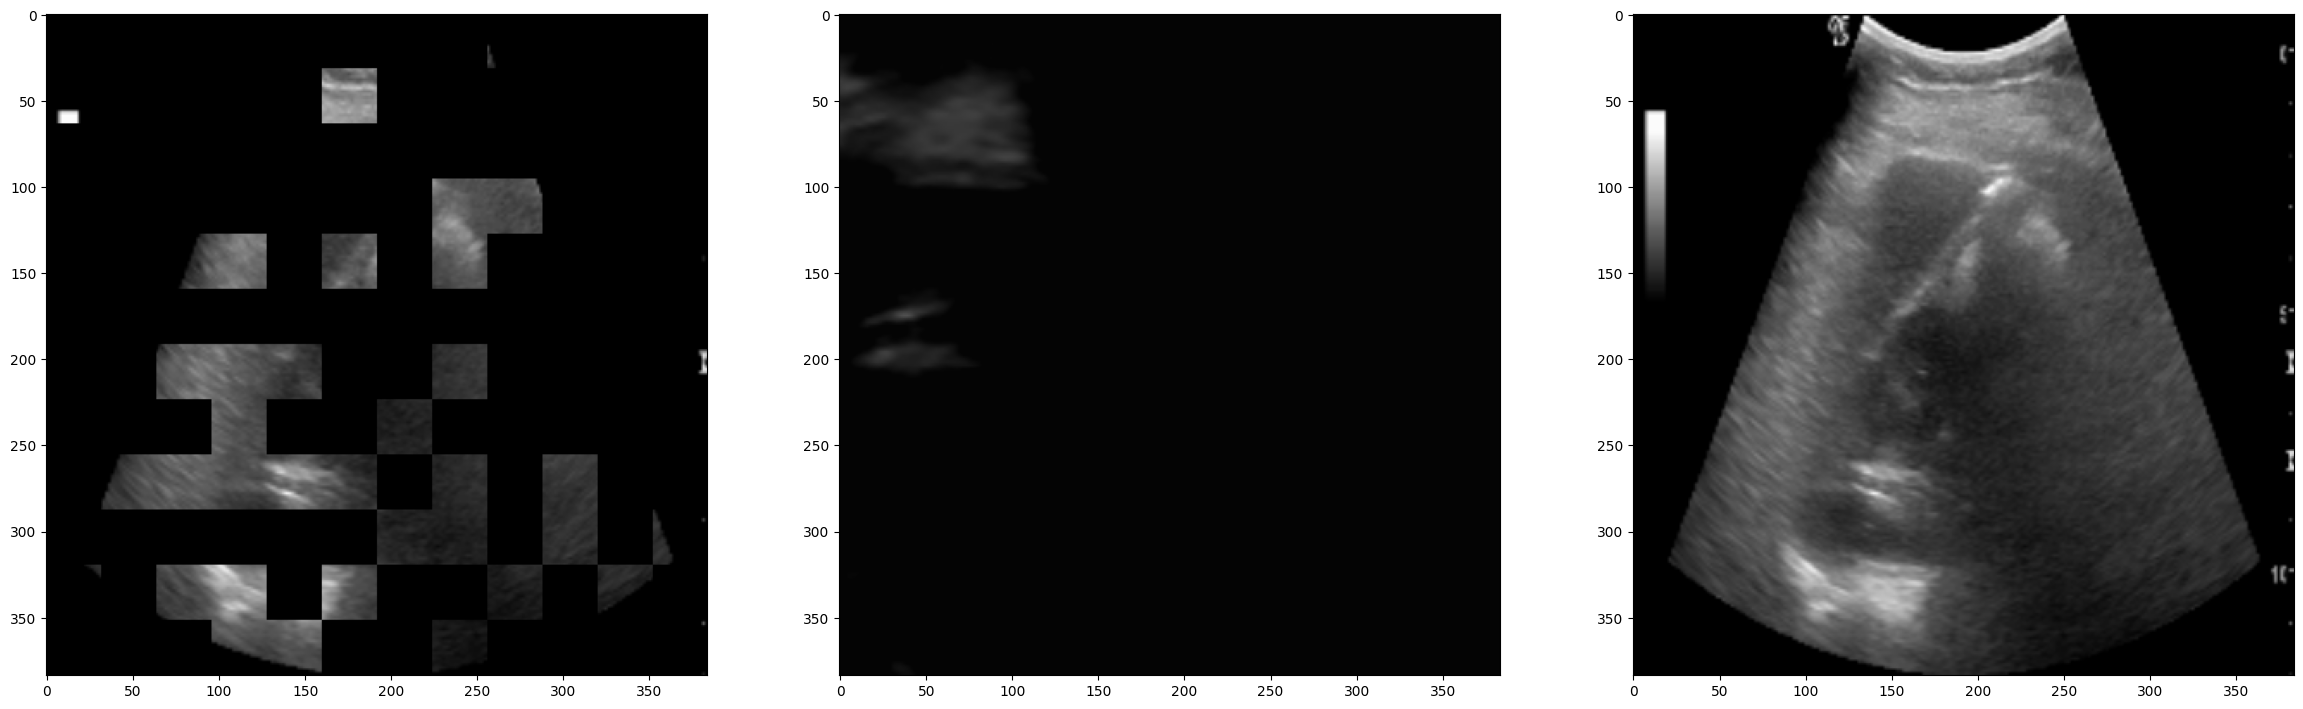

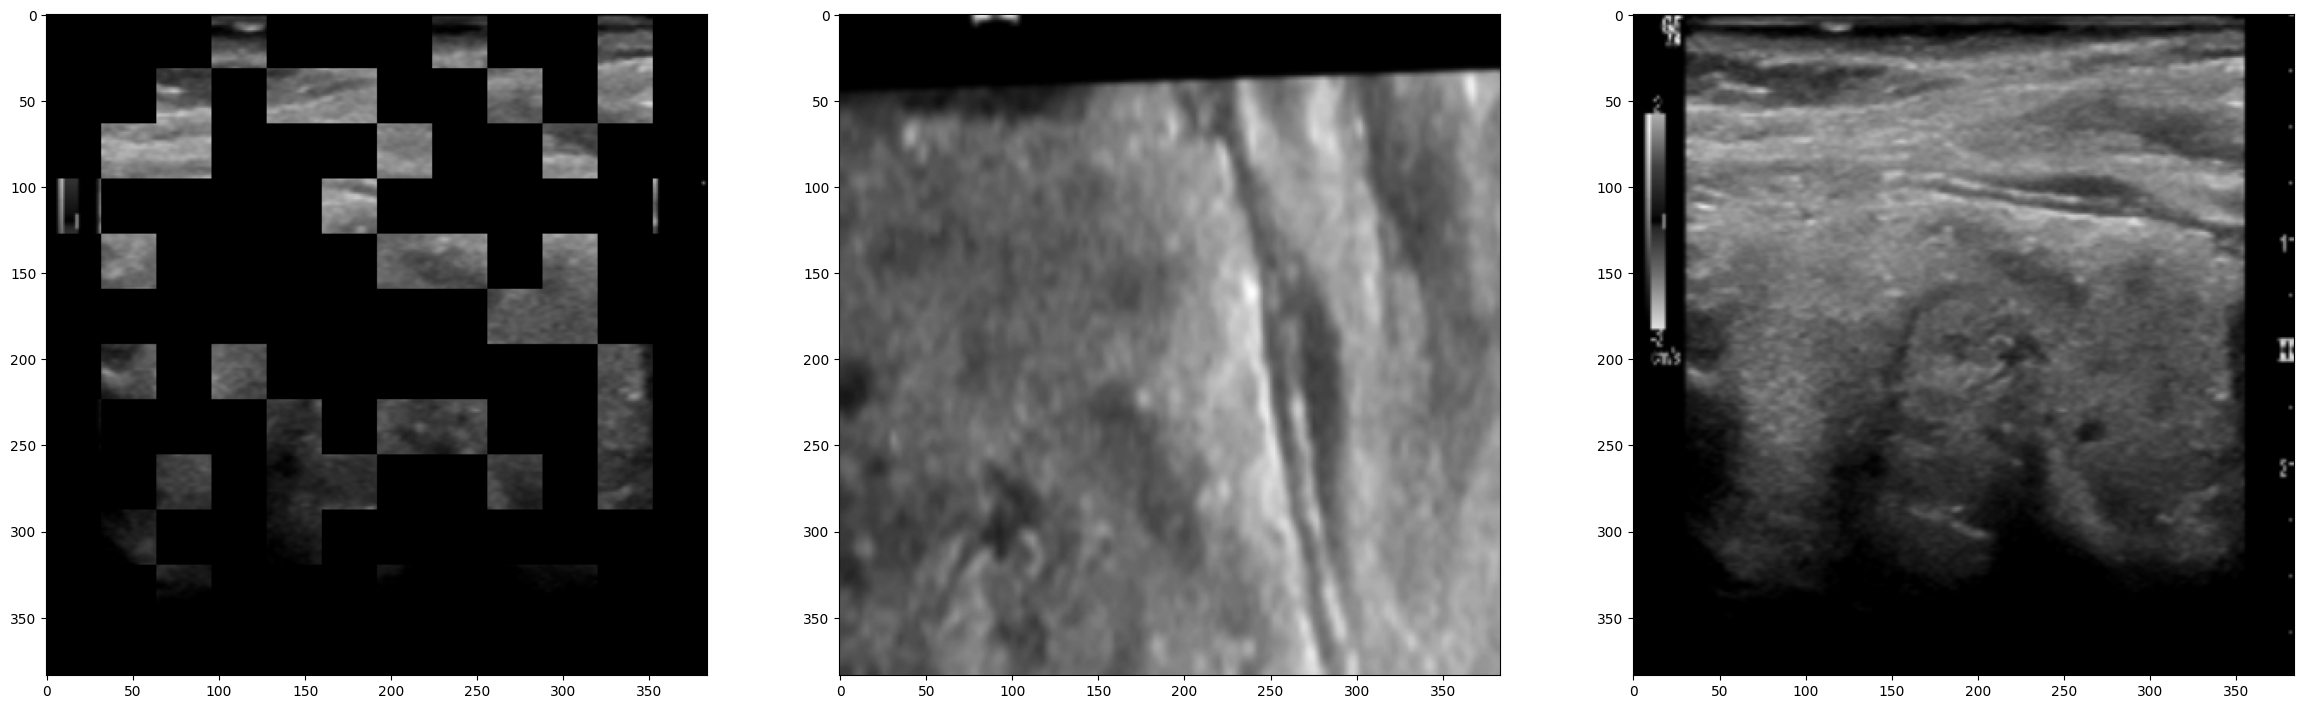

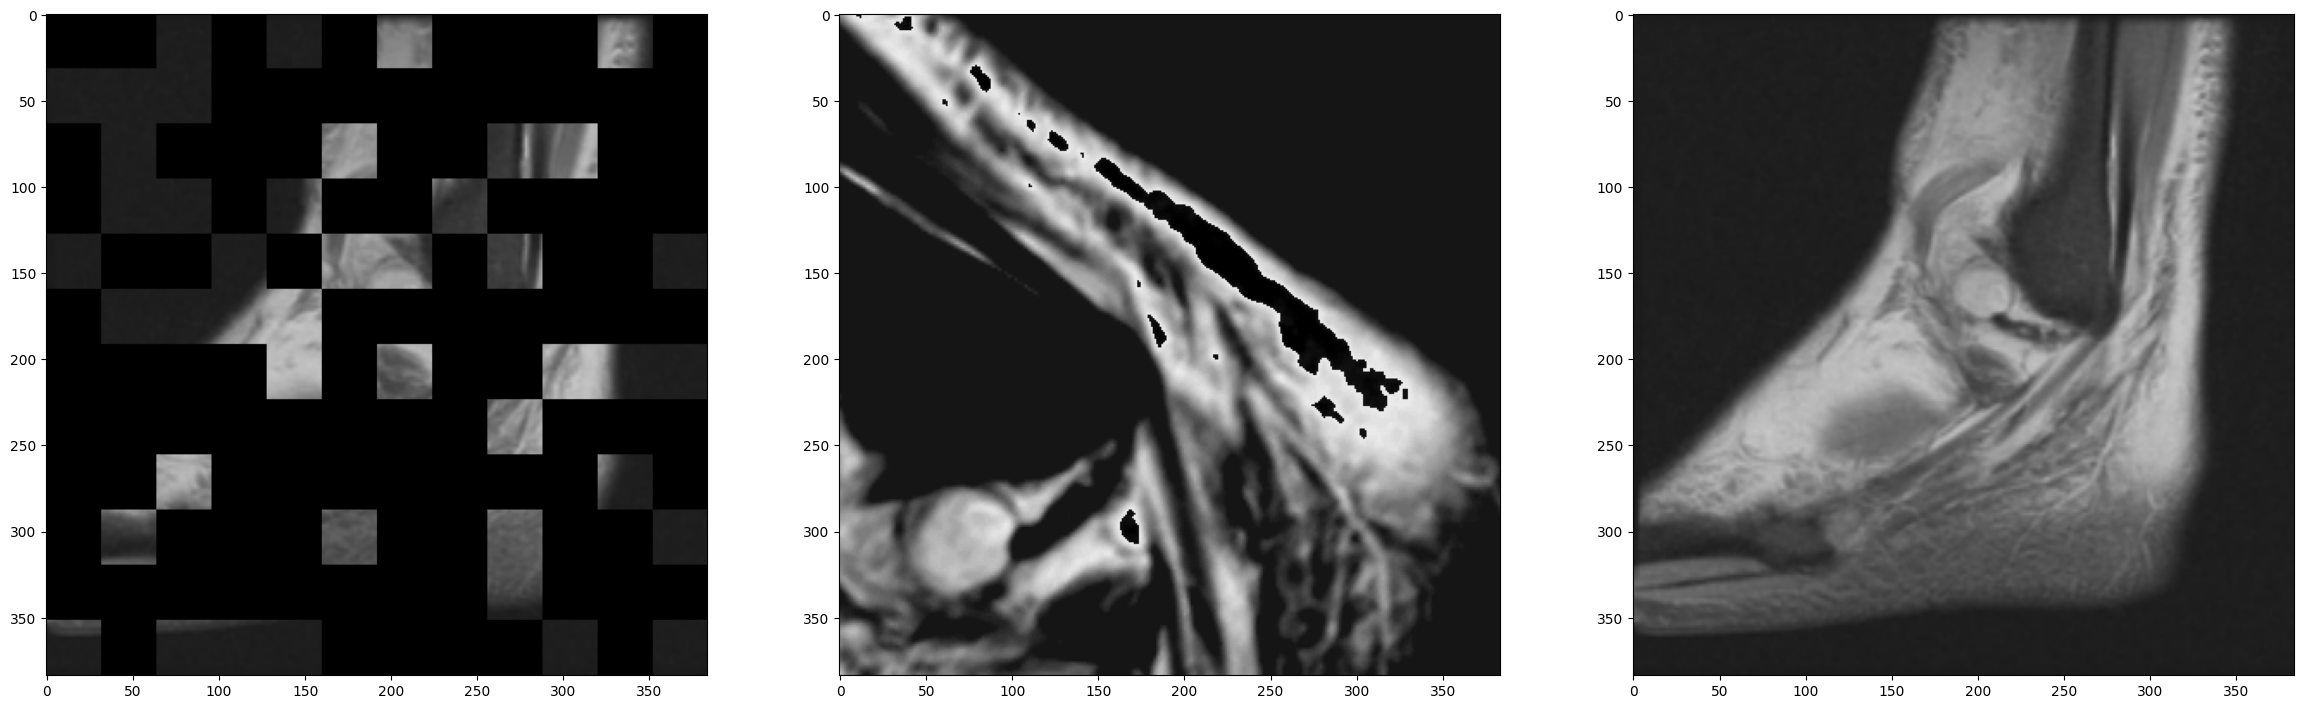

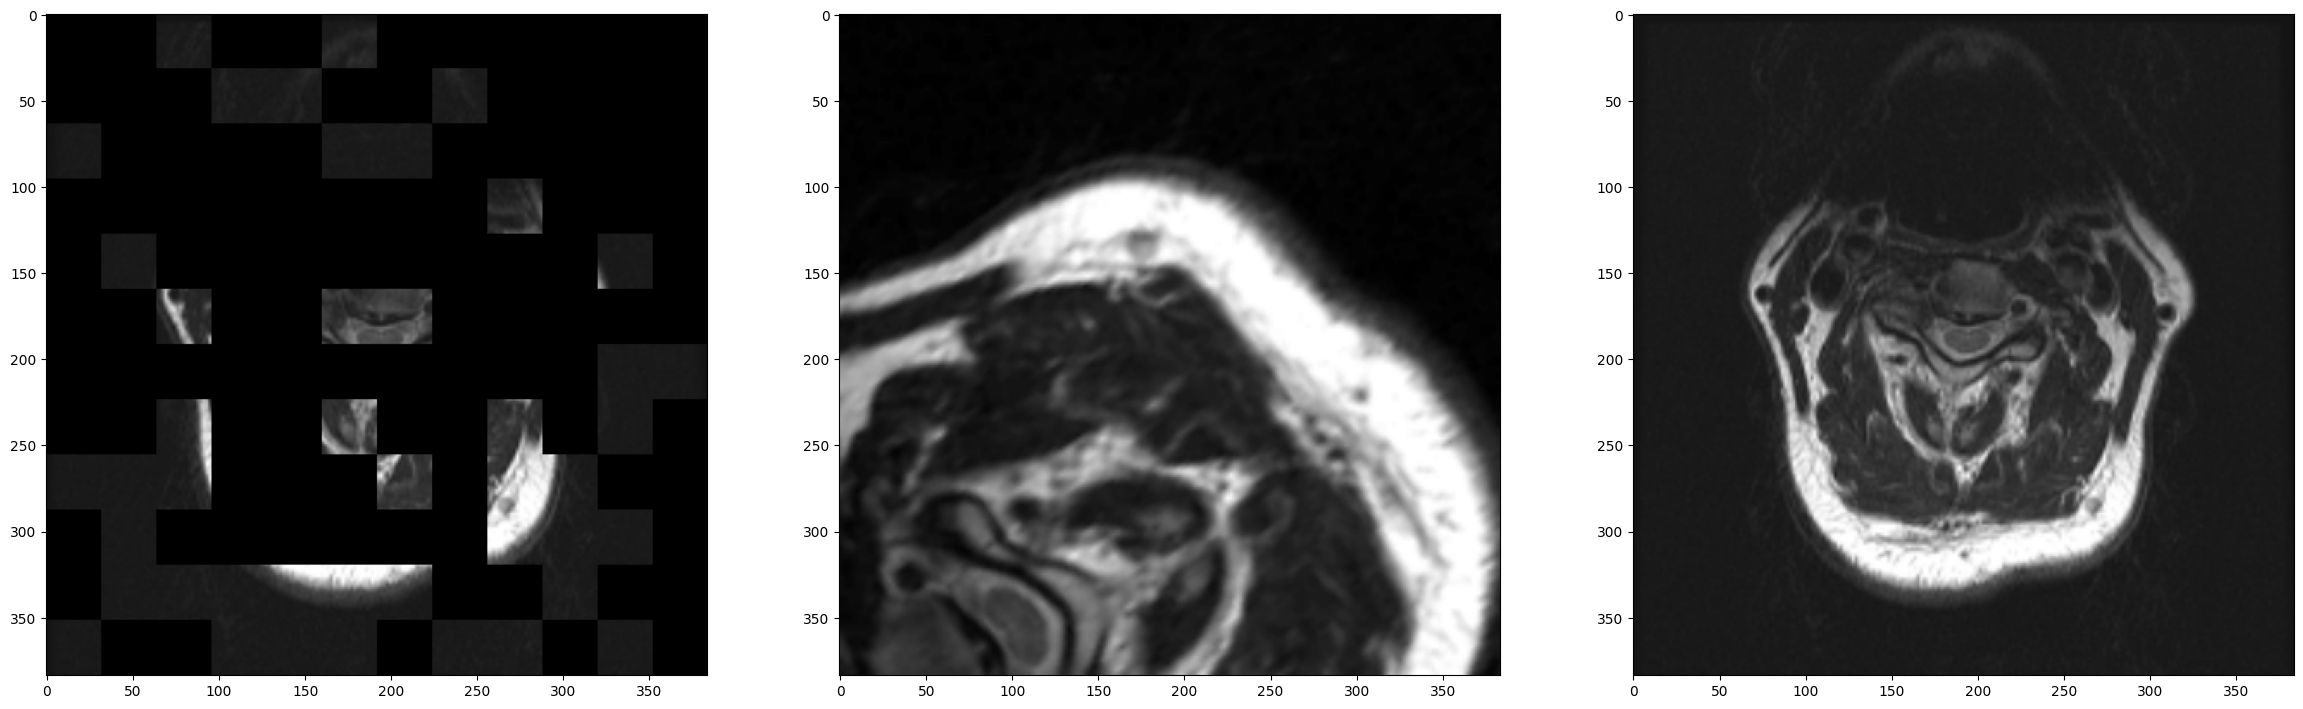

In [21]:
for data in train_ds_masked.take(1):
    seq, img1, img2, img3 = data
for _, img1, img2, img3 in zip(seq, img1, img2, img3):
    fig, axes = plt.subplots(1, 3, figsize = (29, 9))
    axes = axes.flatten()
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    axes[2].imshow(ops.cast(img3, "uint8"))

----------
# Experiment - helper functions

In [ ]:
df_train_rad = pd.read_csv("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RadImgNet_train.csv")
df_train_nih = pd.read_csv("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/nih_trainval_split.csv"
                          )
df_val_rad = pd.read_csv("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/RadImgNet_test.csv")
df_val_nih = pd.read_csv("/kaggle/input/radimagenet-and-nih-cxr-dataset-tfrecord/nih_test_split.csv")


train_cases = len(df_train_rad) + len(df_train_nih) + len(df_val_nih)
val_cases = len(df_val_rad)

train_steps = train_cases//batch_size
val_steps = val_cases//batch_size
print(f"Total train cases : {train_cases}, validation cases : {val_cases}")

In [ ]:
class GCAdamW(keras.optimizers.AdamW):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= ops.mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads
    
class GCAdam(keras.optimizers.Adam):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= ops.mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads

In [ ]:
class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, exp_name, message = None, **kwargs):
        super().__init__(**kwargs)
        self.exp_name = exp_name
        self.message = message if message is not None else " "
    def on_epoch_end(self, epoch, logs=None):
        feature_ext_name = self.model.feature_extractor.name
        save_dir = "/kaggle/working/" ; target_dir = '/kaggle/working/model_save'
        os.makedirs(target_dir, exist_ok = True)
        if (epoch % 1 == 0):
            try:
                print("\nModel Saving to local notebook...")
                file_name = f"{feature_ext_name}_FE{self.exp_name}_Epoch{epoch}_{self.message}.keras"
                filepath = os.path.join(target_dir, file_name)
                saved_dir = self.model.feature_extractor.save(filepath, overwrite=True)
                print("\nModel Uploading to NAS...")
                upload_file(file_name, filepath)
                print("\nModel Saved to Local NAS")
            except Exception as e: 
                print('Model Saving Error:\n', e)
    def on_train_batch_end(self, batch, logs=None):
        feature_ext_name = self.model.feature_extractor.name
        save_dir = "/kaggle/working/" ; target_dir = '/kaggle/working/model_save'
        os.makedirs(target_dir, exist_ok = True)
        if (batch % 50000 == 0) and (batch != 0): 
            try:
                print("\nModel Saving to local notebook...")
                file_name = f"{feature_ext_name}_FE{self.exp_name}_Batch{batch}_{self.message}.keras"
                filepath = os.path.join(target_dir, file_name)
                saved_dir = self.model.feature_extractor.save(filepath, overwrite=True)
                print("\nModel Uploading to NAS...")
                upload_file(file_name, filepath)
                print("\nModel Saved to Local NAS")
            except Exception as e: 
                print('Model Saving Error:\n', e)
                
class TemperatureScheduler(keras.callbacks.Callback):
    def __init__(self, initial_t = 0.5, decay_rate = 0.99):
        super().__init__()
        self.initial_t = initial_t
        self.decay_rate = decay_rate

    def on_train_batch_begin(self, batch, logs=None):
        if not hasattr(self.model, 't'):
            self.model.t = ops.convert_to_tensor(self.initial_t, dtype='float32')
        else:
            if (batch > 0) and (batch % 5000 == 0):
                self.model.t = self.model.t * self.decay_rate

In [ ]:
class TrainingViz(keras.callbacks.Callback):
    def __init__(self, run):
        super().__init__()
        self.run = run
    def on_epoch_end(self, epoch, logs=None):
        try:
            configs = self.model.get_env_config() ; method = configs["SSL_method"]
            if method in ["CLIP" , "SigLIP", "SPARC"]:
                feature_extractor = self.model
            else:
                try:
                    feature_extractor = self.model.feature_extractor
                except:
                    feature_extractor = self.model.get_full_model(res = res)
            viz_weights, merged_weights = ssl_module.att_visualize(feature_extractor, sample_img, res,
                                                  thresholding = 0)
            viz_weights = np.array(viz_weights) #batch, heads, res, res, 3
            merged_weights = np.array(merged_weights)
            heads = viz_weights.shape[1]
            origin = ["Original Image"]
            col = [f"Head{idx + 1}" for idx in range(heads)]
            col = origin + ["Merged"] + col

            visualize_data = []
            for idx, weights in enumerate(viz_weights):
                origin_img = [wandb.Image(sample_img[idx])]
                merged_tmp = [wandb.Image(merged_weights[idx])]
                tmp = [wandb.Image(weights[idx]) for idx in range(heads)]
                tmp = origin_img + merged_tmp + tmp
                visualize_data.append(tmp)
                del tmp, origin_img, merged_tmp
            tbl = wandb.Table(columns = col, data = visualize_data)
            wandb.log({f"Epoch{epoch+1}_{method}_result": tbl})
            del feature_extractor, tbl
            tf.keras.backend.clear_session()
            
            # feature vector visualization
            embed_v = feature_visualize(self.model, sample_img)
            data = [[x, y] for (x, y) in zip(embed_v[..., 0], embed_v[..., 1])]
            table = wandb.Table(data=data, columns = ["x", "y"])
            wandb.log({f"Epoch{epoch+1}_{method}_FeatureViz" : wandb.plot.scatter(table, "x", "y", title="TSNE Scatter Plot")})
            tf.keras.backend.clear_session()

            
        except Exception as e: 
                print('Model Saving Error:\n', e)
        
    def on_train_batch_end(self, batch, logs=None):
        if (batch % (10000) == 0) : 
            try:
                configs = self.model.get_env_config() ; method = configs["SSL_method"]
                if method in ["CLIP" , "SigLIP", "SPARC"]:
                    feature_extractor = self.model
                else:
                    try:
                        feature_extractor = self.model.feature_extractor
                    except:
                        feature_extractor = self.model.get_full_model(res = res)
                viz_weights, merged_weights = ssl_module.att_visualize(feature_extractor, sample_img, res,
                                                      thresholding = False)
                viz_weights = np.array(viz_weights) #batch, heads, res, res, 3
                merged_weights = np.array(merged_weights)
                heads = viz_weights.shape[1]
                origin = ["Original Image"]
                col = [f"Head{idx + 1}" for idx in range(heads)]
                col = origin + ["MergedMap"] + col
                
                visualize_data = []
                for idx, weights in enumerate(viz_weights): #heads, res, res, 3
                    origin_img = [wandb.Image(sample_img[idx])]
                    merged_map = [wandb.Image(merged_weights[idx])]
                    tmp = [wandb.Image(weights[idx]) for idx in range(heads)]
                    tmp = origin_img + merged_map + tmp
                    visualize_data.append(tmp)
                    del tmp, origin_img, merged_map
                tbl = wandb.Table(columns = col, data = visualize_data)
                if batch == 0:
                    wandb.log({f"ZeroBatch_{method}_result": tbl})
                else:
                    wandb.log({f"MidEpoch_{method}_result": tbl})
                del feature_extractor, tbl
                tf.keras.backend.clear_session()
                       
                embed_v = feature_visualize(self.model, sample_img)
                data = [[x, y] for (x, y) in zip(embed_v[..., 0], embed_v[..., 1])]
                table = wandb.Table(data=data, columns = ["x", "y"])
                wandb.log({f"Batch{batch}_{method}_FeatureViz" : wandb.plot.scatter(table, "x", "y", title="TSNE Scatter Plot")})
                tf.keras.backend.clear_session()
                       
            except Exception as e:
                print("Error code in callback : ", e)
           
        else:
            pass

> Real world evaluation and Segmentation callback

In [ ]:
real_world_dir = "/kaggle/input/real-world-medical-image-dataset-for-evaluation" ; filenames_ = os.listdir(real_world_dir)
filenames_.sort()
labels_ = [name.split('.')[0] for name in filenames_]
real_world_files = [os.path.join(real_world_dir, paths) for paths in filenames_]
def get_img_tensor(path, res = res) :
    file = tf.io.read_file(path)
    c =1 if grayscale else 3
    image = tf.io.decode_image(file, channels=c)
    image = tf.image.resize_with_pad(image, res, res, antialias = True)
    image = ops.cast(image, "uint8")
    return image
real_world_images = tf.stack([get_img_tensor(f) for f in real_world_files],
                             axis = 0)

In [ ]:
class RealWorldViz(keras.callbacks.Callback):
    def __init__(self, run):
        super().__init__()
        self.run = run
    
    def on_train_batch_end(self, batch, logs=None):
        if (batch % (5000) == 0) : 
            try:
                configs = self.model.get_env_config() ; method = configs["SSL_method"]
                if method in ["CLIP" , "SigLIP", "SPARC"]:
                    feature_extractor = self.model
                else:
                    try:
                        feature_extractor = self.model.feature_extractor
                    except:
                        feature_extractor = self.model.get_full_model(res = res)
                viz_weights, merged_weights = ssl_module.att_visualize(feature_extractor, real_world_images, res,
                                                      thresholding = False)
                viz_weights = np.array(viz_weights) #batch, heads, res, res, 3
                merged_weights = np.array(merged_weights)
                
                heads = viz_weights.shape[1]
                origin = ["Original Image"]
                col = [f"Head{idx + 1}" for idx in range(heads)]
                col = origin + ["Original Label"] + ["MergedMap"] + col
                visualize_data = []
                for idx, weights in enumerate(viz_weights):
                    origin_img = [wandb.Image(real_world_images[idx])]
                    lab = [labels_[idx]]
                    
                    merged_map = [wandb.Image(merged_weights[idx])]
                    
                    tmp = [wandb.Image(weights[idx]) for idx in range(heads)]
                    tmp = origin_img +lab +  merged_map + tmp
                    visualize_data.append(tmp)
                    del tmp, origin_img, merged_map
                tbl = wandb.Table(columns = col, data = visualize_data)
                if batch == 0:
                    wandb.log({f"RW_ZeroBatch_{method}_result": tbl})
                else:
                    wandb.log({f"RW_Batch{batch}_{method}_result": tbl})
                del feature_extractor, tbl
                tf.keras.backend.clear_session()
                
                embed_v = feature_visualize(self.model, real_world_images)
                data = [[x, y] for (x, y) in zip(embed_v[..., 0], embed_v[..., 1])]
                table = wandb.Table(data=data, columns = ["x", "y"])
                wandb.log({f"RW_Batch{batch}_{method}_FeatureViz" : wandb.plot.scatter(table, "x", "y", 
                                                                                       title=f"RW_Batch{batch}_TSNE")})
                tf.keras.backend.clear_session()
            except Exception as e:
                print("Error code in callback : ", e)
        else:
            pass
        
      

In [ ]:
class SegViz(keras.callbacks.Callback):
    def __init__(self, run, images, labels = None):
        super().__init__()
        self.run = run
        self.images = images
        self.labels = labels
    def on_train_batch_end(self, batch, logs=None):
        configs = self.model.get_env_config() ; method = configs["SSL_method"]
        if (batch % (10000) == 0) and  (method in ["UnsupSeg", "MixedUnsupSeg"]): 
            try:
                heatmap, superimposed_images = self.model.get_segments(self.images)
                origin = ["Original Image"]
                col = origin + ["Original Label"] + ["Segmentation Result"]
                visualize_data = []
                for idx, sup_img in enumerate(superimposed_images):
                    origin_img = [wandb.Image(self.images[idx])]
                    if self.labels is None:
                        lab = ["Label not provided."]
                    else:
                        lab = [self.labels[idx]] 
                    tmp = [wandb.Image(sup_img)]
                    tmp = origin_img + lab + tmp
                    visualize_data.append(tmp)
                    del tmp, origin_img
                tbl = wandb.Table(columns = col, data = visualize_data)
                if batch == 0:
                    wandb.log({f"Seg_ZeroBatch_{method}_result": tbl})
                else:
                    wandb.log({f"Seg_MidEpoch_{method}_result": tbl})
                
                tf.keras.backend.clear_session()
            except Exception as e:
                print("Error code in Segmentation callback : ", e)
        else:
            pass

In [ ]:
def run_exp(model, train_ds = train_ds, val_ds = val_ds, epochs = 10, note= None, exp_name = None):
    try:
        wandb.finish()
    except:
        pass
    
    if True :
        wandb_config()
        configs = model.get_env_config()
        method = configs["SSL_method"]
        try:
            feature_extractor = model.feature_extractor
        except:
            feature_extractor = model.get_full_model(res = res)
        
        if method in ['CLIP', "SigLIP", "SPARC"]:
            _ = model((example_images[:2], example_reports[:2]))
        elif method in ["SimMIM", "MixedMIM","DistilMIM", "MixedUnsupSeg", 
                        "NCLR_nnclr_without_momentum", 'NCLR_snclr_without_momentum']:
            pass
        else:
            _ = model(test_set)
        feature_extractor_flops = get_flops(feature_extractor, [tf.random.normal([1,res,res,c])])
        del feature_extractor
        
        env_config = {"batch_size" : batch_size, "Patch size": patch_size,
                      "original resolution" : res, "local view resolution" : small_res,
                     "Training steps" : train_steps,
                     "Val steps" : val_steps,
                     "train cases" : train_cases,
                     "val cases" : val_cases,
                     "embed_dims" : embed_dims,
                     "Image resolution" : res,
                     "(Image) Encoder Flops(G)" : feature_extractor_flops,
                     "dtype" : keras.mixed_precision.dtype_policy(),
                      "Optimizer configs" : model.optimizer.get_config(),
                      "Multicrop N" : n_multicrop, "metaencoder depth" : depth, 'embedding dims' : embed_dims,
                     }
        configs.update(env_config)
        
        wd = "/kaggle/working/"
        file_name = os.path.join(wd, f"{method}_radimgnet_mini.keras")
        print(configs, "\n\n")
        
        run = wandb.init(project="RadImageNet", 
                         entity="gongbungkim", config = configs, notes = note,
                        name = exp_name)

        pass_error = keras.callbacks.TerminateOnNaN()
        wb_callback = wandb.keras.WandbMetricsLogger(log_freq = 100)
        
        callbacks = [pass_error, wb_callback, ModelSaveCallback(f"RI_SSL_{method}", note), 
                     TrainingViz(run),
                    RealWorldViz(run),
                    SegViz(run, images = sample_img),
                    SegViz(run, images = real_world_images, labels = labels_),
                    TemperatureScheduler()]
        if val_ds is not None:
            hist = model.fit(train_ds, 
                             steps_per_epoch = train_steps, 
                             epochs = epochs, 
                             validation_data = val_ds, 
                             validation_steps = val_steps, 
                             verbose = 1,
                             callbacks = callbacks)
        else:
            hist = model.fit(train_ds, 
                         steps_per_epoch = train_steps, 
                         epochs = epochs, 
                         verbose = 1,
                         callbacks = callbacks)
    return hist

In [ ]:
cosine_decay = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = 1e-6,
    decay_steps = int(0.5*train_steps),
    alpha=1e-5,
    name='CosineDecay',
    warmup_target=2e-4,
    warmup_steps=train_steps - int(0.3*train_steps)
)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 2e-4,
    decay_steps=20000,
    decay_rate=0.75,
    staircase=True)

In [ ]:
def ssl_train(module, feature_extractor, learning_rate = lr_schedule,
              embed_dims = embed_dims, multiview = True, gradient_accumulation = None, use_ema = False,
             note = "", name = "",
             apply_barlow = False, apply_simclr = False):
    try:
        ssl_trainer = module(feature_extractor, embed_dims = embed_dims, multiview = multiview,
                            apply_barlow = apply_barlow, apply_simclr = apply_simclr)
    except Exception as e:
        print("Error : ",e)
        ssl_trainer = module(feature_extractor, embed_dims = embed_dims, multiview = multiview)
    ssl_trainer.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate,
                                                         clipnorm = 0.5,
                                                         #amsgrad = True,
                                                           gradient_accumulation_steps=gradient_accumulation,
                                                         use_ema = use_ema),
                        jit_compile = False
                      )
    
    run_exp(ssl_trainer, train_ds_multiview, None, epochs = 100,
       note = note, exp_name = name)

In [ ]:
ibot = 0
other = 0
mim = 0
sobel_other = 1

In [ ]:
if mim:
    model_ = 'attention'
    vanilla_model = ssl_module.get_metaformer(model_, res = res, embed_dims = embed_dims, 
                                              att_depth = depth, att_heads = heads,
                                              att_dims = att_dims,
                                              grayscale = grayscale, patch_size = patch_size, 
                                              register_tokens = registers,
                                             pretrained_encoder = pretrained_encoder,
                                             return_patches = True)
    vanilla_model.summary()
    ssl_trainer = ssl_module.MixedMIM(vanilla_model, grayscale = grayscale, patch_size = patch_size)
    ssl_trainer.compile(optimizer = keras.optimizers.AdamW(learning_rate = cosine_decay, 
                                                           clipnorm = 1.0,
                                                           #gradient_accumulation_steps=64,
                                                           use_ema = True
                                                          ),
                        jit_compile = False
                      )
    configs = ssl_trainer.get_env_config()
    method = configs["SSL_method"]
    run_exp(ssl_trainer, train_ds_edge_masked, None, 
           note = pretrained_note+"_"+model_, exp_name = f"SobelMerging_Patch{patch_size}_{method}_{model_}")

In [ ]:
if sobel_other:
    if True:
        model_ = 'attention'
        vanilla_model = ssl_module.get_metaformer(model_, res = res, embed_dims = embed_dims, 
                                                  att_depth = depth, att_heads = heads,
                                                  att_dims = att_dims,
                                                  grayscale = grayscale, patch_size = patch_size, 
                                                  register_tokens = registers,
                                                 pretrained_encoder = pretrained_encoder,
                                                 return_patches = True)
        vanilla_model.summary()
        #ssl_trainer = ssl_module.MixedMIM(vanilla_model, grayscale = grayscale, patch_size = patch_size)
        ssl_trainer = ssl_module.NCLR(vanilla_model, embed_dims = embed_dims, subtype = "nnclr", use_mim = True, patch_size = patch_size)
        ssl_trainer.compile(optimizer = keras.optimizers.AdamW(learning_rate = 5e-5, 
                                                               clipnorm = 1.0,
                                                               gradient_accumulation_steps=128,
                                                              ),
                            jit_compile = False,
                            
                          )
        configs = ssl_trainer.get_env_config()
        method = configs["SSL_method"]

        run_exp(ssl_trainer, train_ds_masked, None, 
               note = pretrained_note+"_"+model_, exp_name = f"{method}_{model_}_StrongAug_mim")


In [ ]:
if ibot:
    ssl_trainer = ssl_module.iBOT(att_depth = depth, att_dims = att_dims, att_heads = heads,
                                  embed_dims = 2048, patch_size = patch_size,

                                  multiview = True, apply_simclr = False,
                                  grayscale = True
                                 )
    ssl_trainer.compile(optimizer = keras.optimizers.AdamW(learning_rate = lr_schedule,
                                                         clipnorm = 1.0, use_ema = True),
                       jit_compile = False)
    run_exp(ssl_trainer, train_ds_multiview, None, epochs = 100,
           note = "+ NEW aug, New Patching", exp_name = "iBOT_VanillaViT")

In [ ]:
if other:
    model_ = 'gMLP'
    if pretrained_encoder is None:
        note = "From Scratch"
        assert grayscale is True, "If building from scratch, make sure [grayscale = True]"
    else:
        note = f"With pretrained {pretrained_encoder.name}"
        assert grayscale is False, "If using pretrained network, make sure [grayscale = False]"
    vanilla_model = ssl_module.get_metaformer(model_, res = res, embed_dims = embed_dims, 
                                              att_depth = depth, att_heads = heads,att_dims = att_dims,
                                              grayscale = grayscale, patch_size = patch_size, 
                                              register_tokens = 4,
                                             pretrained_encoder = pretrained_encoder)
    ssl_train(ssl_module.DINO, vanilla_model, 
             note = note + " / 2-view",
             name = f"DINO_{model_}_reg",
             learning_rate = lr_schedule,
             multiview = False,
             gradient_accumulation = 32)